#### Visualising intermediate activations

In [ ]:
from keras.models import load_model

In [3]:
# Re-load a previously trained model
model = load_model("/home/ec2-user/models/cats_and_dogs/cats_and_dogs_small_2.h5")

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [5]:
# Load an image the model hasn't been trained on
img_path = '/home/ec2-user/datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


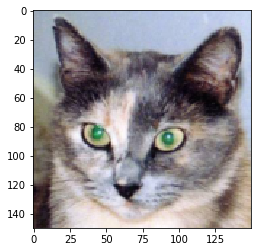

In [7]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [8]:
# We now instantiate a model from an input tensor and a list of output tensors
from keras import models

# Extract the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]
# And now we create a model which returns the outputs given an input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [9]:
# We can now get the 8 outputs (the 8 layers activations) as an array
activations = activation_model.predict(img_tensor)

In [16]:
# Looking at the first layer in the summary, we can see what its dimensions should be
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


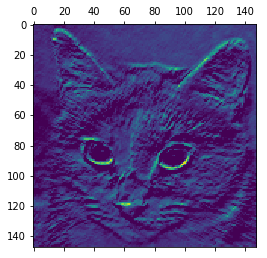

In [22]:
# We can now print the fourth channel
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()

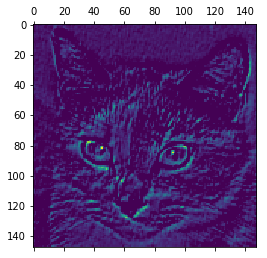

In [26]:
# And the 7th
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

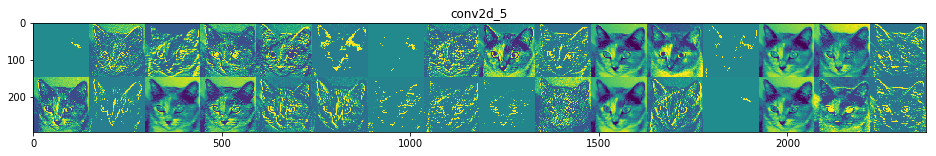

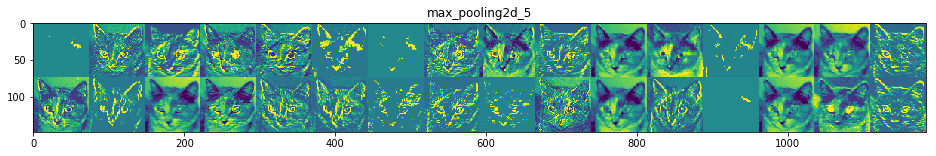

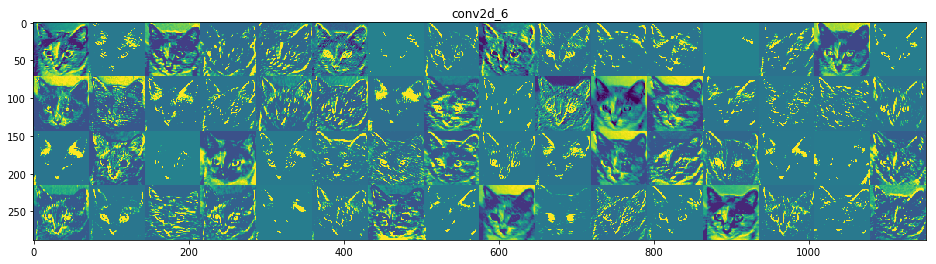

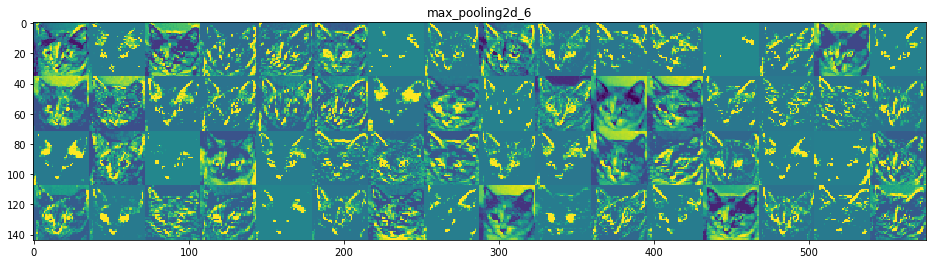

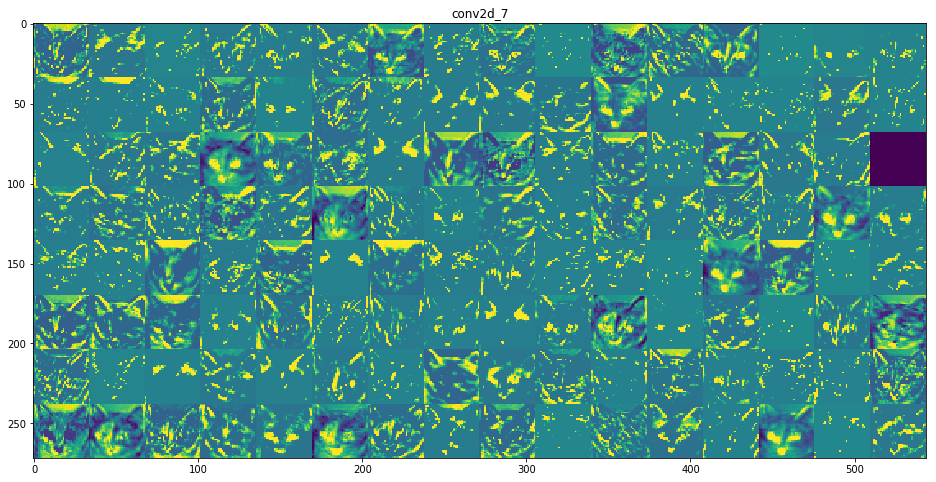

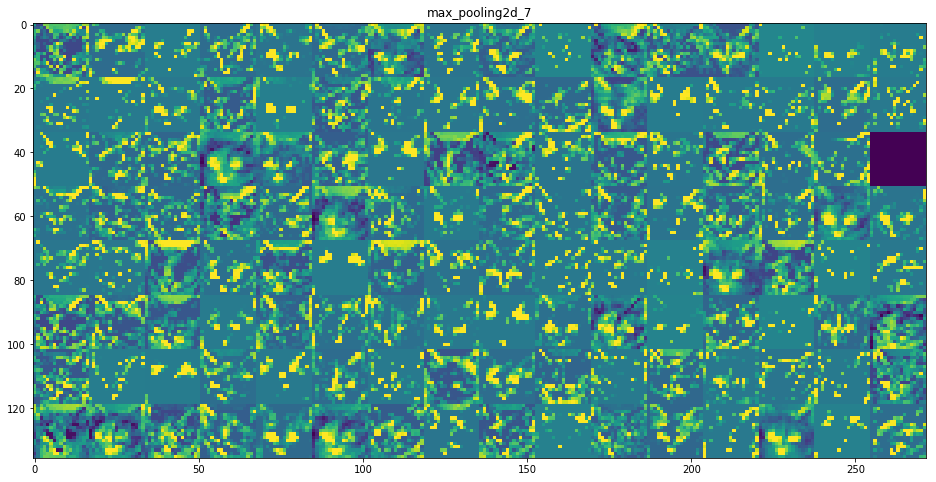

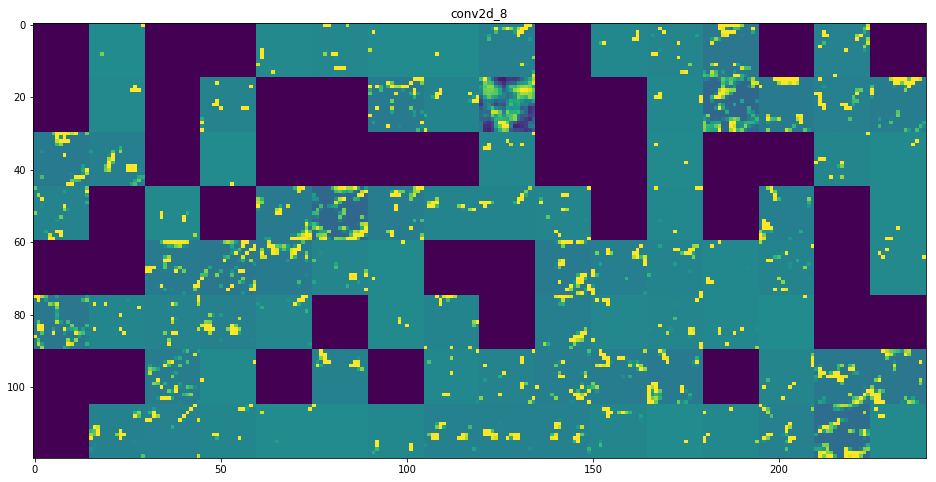

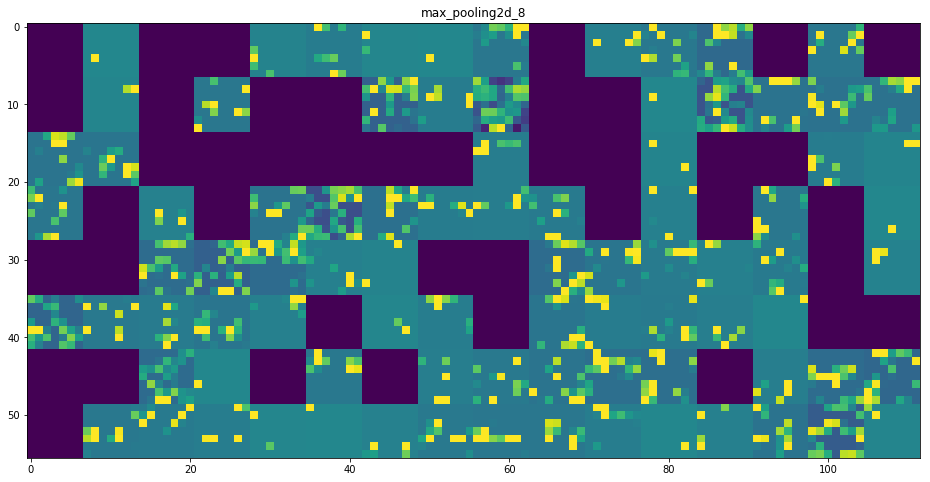

In [32]:
# Each channel from each layer "specialises" in extracting different features. We can now visualise
# all the channels in the 8 activation maps.
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std() + 1e-5
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

#### Visualizing convnets filters

In [33]:
# We now want to inspect the learnt filters by trying to visualise the image a filter is maximally
# responsive to. We do that by building a loss function that maximises the value of a given filter
# in a given convolutional layer, and then we use stochastic gradient descent to adjust the weights 
# in order to maximise the activation value.

# For instance, here’s a loss for the activation of filter 0 in the layer block3_conv1 
# of the VGG16 network, pretrained on ImageNet.

from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',
                      include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [36]:
# Now let's get the gradient of the loss
grads = K.gradients(loss, model.input)[0]
# We also use a gradient normalisation by dividing it by its L2 norm. This makes the process
# go more smoothly
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [37]:
# Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image
# We define the following function to do this:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [38]:
# And then we define a loop to do gradient descent
# We start from gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [39]:
# The resulting image tensor is a floating-point tensor of shape (1, 150, 150, 3), 
# with values that may not be integers within [0, 255]. 
# Hence, we need to postprocess this tensor to turn it into a displayable image. 
# We do so with the following straightforward utility function.
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [40]:
# Let's now put everything together into a single python function that takes as input
# a layer name and a filter index, and returns a valid image tensor which represents
# the pattern that maximises the filter's activation response
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)                  

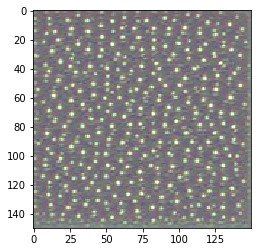

In [42]:
# We can now try it. We can see that this filter in the layer appears to have been trained
# to respond to a polka dot pattern
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

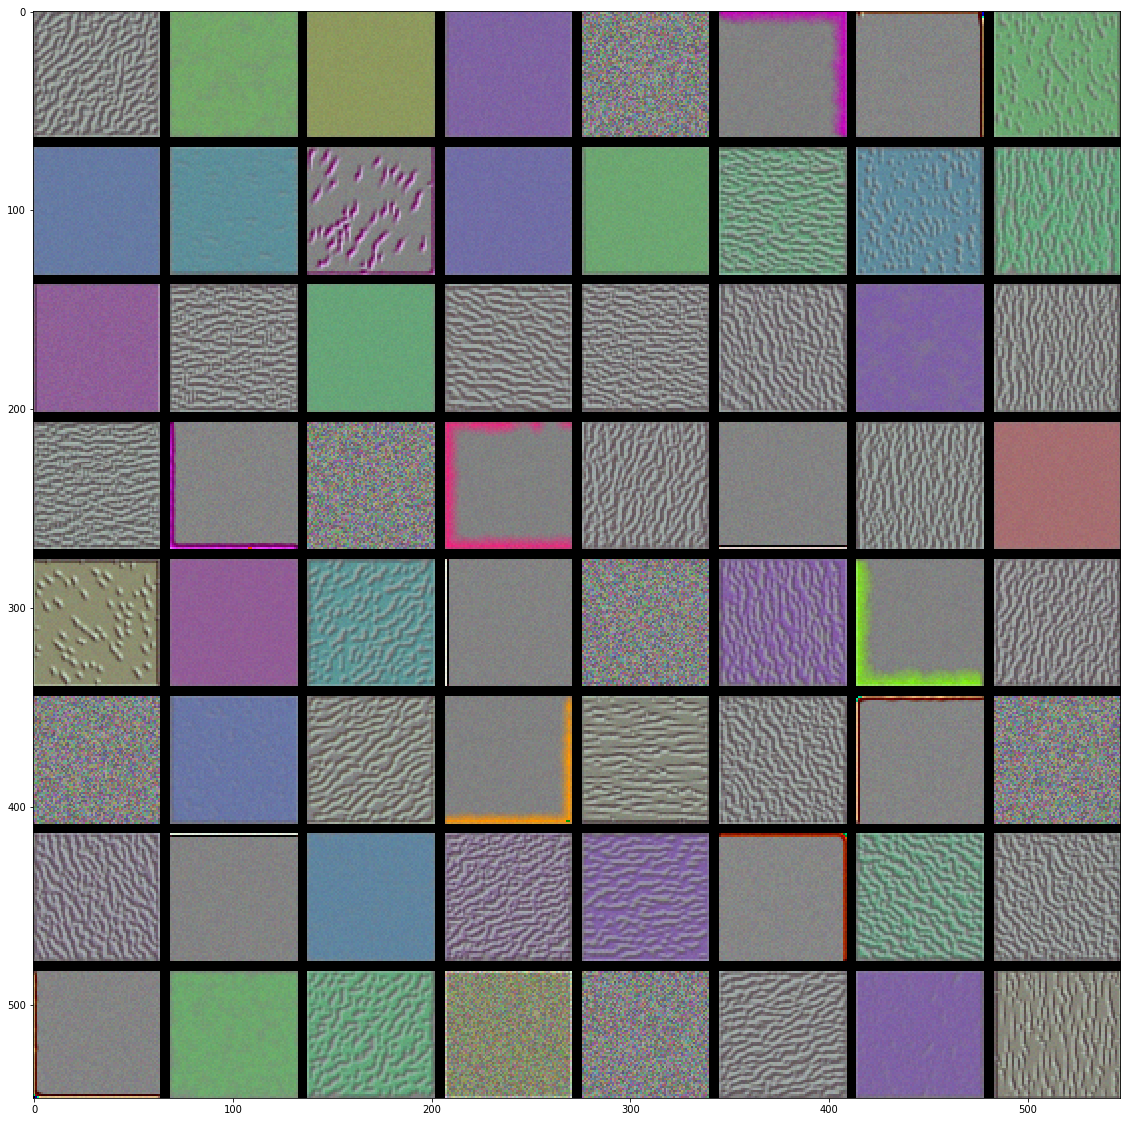

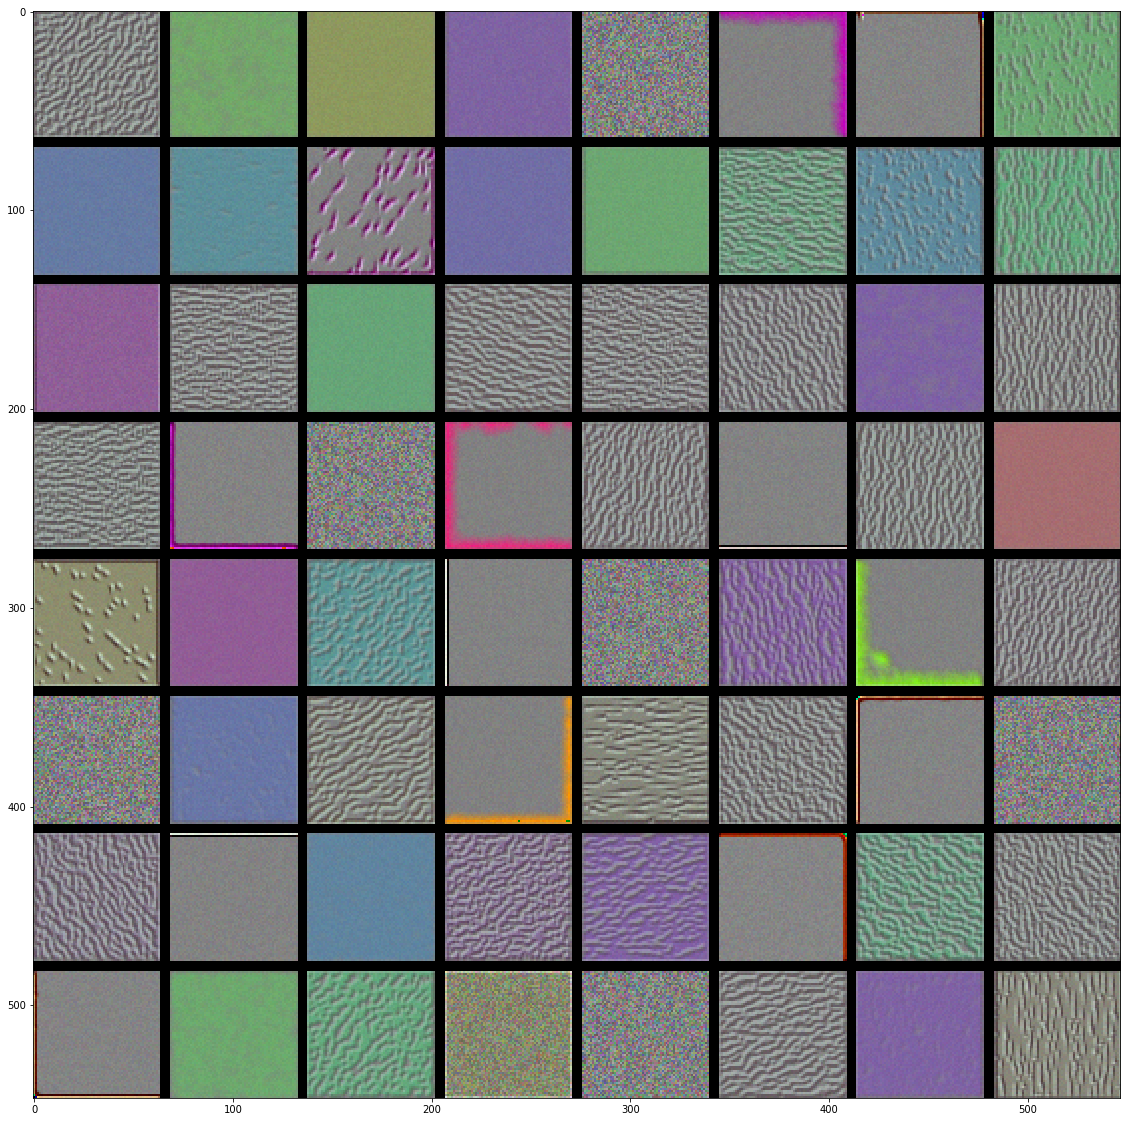

In [44]:
# And now let's look at more filters, from the first layer of each convolutional block
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()